In [1]:
!python -V
!pip show torch

Python 3.8.8
Name: torch
Version: 1.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\users\b\appdata\local\programs\python\python38\lib\site-packages
Requires: numpy, future
Required-by: torchviz, torchvision


### In the New CNN
- There is no notion of accuracy
- The loss function is RMSE

- One thing is to train CNN model in traffic data that is GC_GRNN training data. No limit on how much data we can use to train.

- another thing is to train CNN model in GC_GRNN inputs and prediction pairs to replicate it. with as few queries as possible.

### Oracle vs. using the same training data

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from Resnet_adaptation import new_cnn_model

In [3]:
# set seeds
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
# Set compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [2]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [4]:
training_set['x'].shape

(9157, 12, 150, 1)

In [6]:
# data sources: Configured for oracle

# The training data used to train HA
inputs = np.load('./ha/train_inputs.npy', allow_pickle= True)
print(f'shape = {inputs.shape}, Max = {np.max(inputs)}')

ground_truths = np.load('./ha/train_gts.npy', allow_pickle= True)
print(f'shape = {ground_truths.shape}, Max = {np.max(ground_truths)}')

# Predictions of HA on the inputs i.e. training set itself
preds_on_inputs = np.load('./ha/train_preds.npy', allow_pickle= True)
print(f'shape = {preds_on_inputs.shape}, Max = {np.max(preds_on_inputs)}')

shape = (2016, 12, 150), Max = 13442.0
shape = (2016, 12, 150), Max = 13442.0
shape = (2016, 12, 150), Max = 11012.2


In [7]:
# Norm/ Denorm
# We need all 3 sources to have same shape
# We need all 3 sources to be normalized
inputs = (inputs - mean)/std
ground_truths = (ground_truths - mean)/std
# gcgrnn_preds are already normalized
preds_on_inputs = (preds_on_inputs - mean)/std

print(f'shape = {inputs.shape}, Max = {np.max(inputs)}')
print(f'shape = {ground_truths.shape}, Max = {np.max(ground_truths)}')
print(f'shape = {preds_on_inputs.shape}, Max = {np.max(preds_on_inputs)}')

shape = (2016, 12, 150), Max = 4.321317505279355
shape = (2016, 12, 150), Max = 4.321317505279355
shape = (2016, 12, 150), Max = 3.1985361052451604


#### Training of ResNet will be done in (inputs, gcgrnn predictions) pair
#### Testing will be done to just test inputs

In [8]:
x_train = inputs
# Oracle means, y = gcgrnn preds
y_train = preds_on_inputs
print("Training data: ", len(x_train), len(y_train))

Training data:  2016 2016


In [9]:
# Define dataset
class TR_dataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        
    def __len__(self):
        assert len(self.target_list) == len(self.data_list)
        return len(self.data_list)

    def __getitem__(self, key):
        input_seq = self.data_list[key]
        targets = self.target_list[key]
        return [input_seq,targets]

In [10]:
# Make dataloaders
# Shuffle set to False

BATCH_SIZE = 24

train_set = TR_dataset(x_train, y_train)

train_dataloader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)

In [11]:
# Instantiate a ResNet adaptation model here
# See the model file for full model architecture
model = new_cnn_model.ResNet_Adaptation_model()
model = model.float().to(device)

In [12]:
# MSE
criterion = nn.MSELoss(reduction='mean')
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [13]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, (batch_input, batch_target) in enumerate(iterator):
        
        batch_input = batch_input.float().to(device)
        #print(batch_target.shape)
        batch_target = torch.flatten(batch_target.float(), start_dim=1).to(device)
        #print(batch_target.shape)
        optimizer.zero_grad()
        
        output = model(batch_input)
        
        mse_loss = criterion(output, batch_target)
        #RMSE, MSE not enough
        loss = torch.sqrt(mse_loss)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.cpu().detach().numpy()
        #epoch_loss+=loss.item()
        
    # Average batch loss in an epoch
    return epoch_loss/len(iterator) 

In [14]:
# can include a validation loss every epoch
def validate():
    return 0

In [15]:
# No need to apply softmax or measure accuracy 

# For now only 350, later change to 1500
num_epochs = 50
#num_epochs = 2

# Over total epochs
loss_epoch =[]
best_loss = float('inf')

for i in range(num_epochs):
    
    # Loss is averaged in an epoch. so this is average batch loss per epoch
    loss = train(model, train_dataloader, optimizer,criterion )
    print("Normalized RMSE Loss (Average Batch Loss)=", loss)
    
    if loss < best_loss:
        best_loss = loss
        # Save the entire model, not just state_dict
        torch.save(model, './ha/best_model_CNN.pt')
        
    loss_epoch.append(round(loss,2))
print("Best Loss = ", best_loss)

Normalized RMSE Loss (Average Batch Loss)= 0.8644181731201354
Normalized RMSE Loss (Average Batch Loss)= 0.3947066611477307
Normalized RMSE Loss (Average Batch Loss)= 0.31012663883822306
Normalized RMSE Loss (Average Batch Loss)= 0.29193982144906405
Normalized RMSE Loss (Average Batch Loss)= 0.25166447336475056
Normalized RMSE Loss (Average Batch Loss)= 0.2546942934748672
Normalized RMSE Loss (Average Batch Loss)= 0.2289484641736462
Normalized RMSE Loss (Average Batch Loss)= 0.22176285247717584
Normalized RMSE Loss (Average Batch Loss)= 0.22978191627633004
Normalized RMSE Loss (Average Batch Loss)= 0.2182410563386622
Normalized RMSE Loss (Average Batch Loss)= 0.19679997346940495
Normalized RMSE Loss (Average Batch Loss)= 0.19942090216846692
Normalized RMSE Loss (Average Batch Loss)= 0.19002744129725865
Normalized RMSE Loss (Average Batch Loss)= 0.19226591661572456
Normalized RMSE Loss (Average Batch Loss)= 0.18747630981462343
Normalized RMSE Loss (Average Batch Loss)= 0.174232130426736

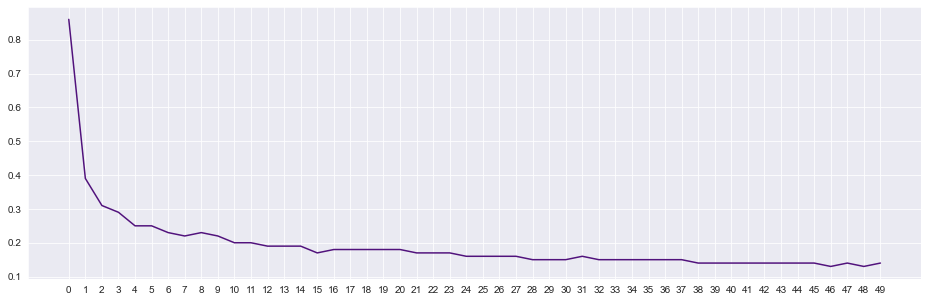

In [16]:
# Train loss curve
x = np.arange(num_epochs)
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(x, loss_epoch)
ax.set_xticks(x);

### ResNet performance in the test set

In [17]:
test_inputs = np.load('./ha/test_inputs.npy', allow_pickle = True)
test_gts = np.load('./ha/test_gts.npy', allow_pickle = True)
test_preds = np.load('./ha/test_preds.npy', allow_pickle = True)

print(f'shape = {test_inputs.shape}, Max = {np.max(test_inputs)}')
print(f'shape = {test_gts.shape}, Max = {np.max(test_gts)}')
print(f'shape = {test_preds.shape}, Max = {np.max(test_preds)}')

test_inputs = (test_inputs - mean)/std
test_gts = (test_gts - mean)/std
test_preds = (test_preds - mean)/std

print(f'shape = {test_inputs.shape}, Max = {np.max(test_inputs)}')
print(f'shape = {test_gts.shape}, Max = {np.max(test_gts)}')
print(f'shape = {test_preds.shape}, Max = {np.max(test_preds)}')

x_test = test_inputs
y_test = test_preds

print("Testing data: ", len(x_test), len(y_test))

shape = (2609, 12, 150), Max = 11644.0
shape = (2609, 12, 150), Max = 11644.0
shape = (2609, 12, 150), Max = 11012.2
shape = (2609, 12, 150), Max = 3.4904832978295723
shape = (2609, 12, 150), Max = 3.4904832978295723
shape = (2609, 12, 150), Max = 3.1985361052451604
Testing data:  2609 2609


In [18]:
TEST_BATCH_SIZE =1
test_set = TR_dataset(x_test,y_test)
test_dataloader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=TEST_BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)

In [19]:
trained_model = torch.load('./ha/best_model_CNN.pt')
trained_model.eval()
outputs = []

with torch.no_grad():
    for bi, (data, target) in enumerate(test_dataloader):
        
        data_batch, label_batch = data.float().to(device), target.float().to(device)
        
        output_batch = trained_model(data_batch)
        
        # add cpu() before detach if device changed to GPU
        output_batch_numpy = output_batch.cpu().detach().numpy().reshape(12,-1)
        
        #print(output_batch_numpy.shape)
        outputs.append(output_batch_numpy)
outputs = np.array(outputs)
print(outputs.shape)

np.save('./ha/resnet_test_output.npy', outputs)

(2609, 12, 150)


In [20]:
# From the test set
inputs = test_inputs
print(f'Inputs: shape = {inputs.shape}, min = {np.min(inputs)}, max = {np.max(inputs)}')

# ground truths of these inputs
# The could be y_test as well
gts_test = test_gts
print(f'GTS: shape = {gts_test.shape}, min = {np.min(gts_test)}, max = {np.max(gts_test)}')

# HA preds
ha_preds = test_preds
print(f'HA Preds: shape = {ha_preds.shape}, min = {np.min(ha_preds)}, max = {np.max(ha_preds)}')

# ResNet preds
resnet_preds = np.load('./ha/resnet_test_output.npy', allow_pickle = True)
print(f'ResNetPreds: shape = {resnet_preds.shape}, min = {np.min(inputs)}, max = {np.max(resnet_preds)}')

#Denormalize everything
inputs = inputs*std+mean
print(f'\nInputs: shape = {inputs.shape}, min = {np.min(inputs)}, max = {np.max(inputs)}')

gts_test = gts_test*std+mean
print(f'GTS: shape = {gts_test.shape}, min = {np.min(inputs)}, max = {np.max(gts_test)}')

ha_preds = ha_preds*std+mean
print(f'HA Preds: shape = {ha_preds.shape}, min = {np.min(ha_preds)}, max = {np.max(ha_preds)}')

resnet_preds = resnet_preds*std+mean
print(f'ResNetPreds: shape = {resnet_preds.shape}, min = {np.min(inputs)}, max = {np.max(resnet_preds)}')

Inputs: shape = (2609, 12, 150), min = -1.8900692669898203, max = 3.4904832978295723
GTS: shape = (2609, 12, 150), min = -1.8900692669898203, max = 3.4904832978295723
HA Preds: shape = (2609, 12, 150), min = -1.8319385977477831, max = 3.1985361052451604
ResNetPreds: shape = (2609, 12, 150), min = -1.8900692669898203, max = 3.549380302429199

Inputs: shape = (2609, 12, 150), min = 0.0, max = 11644.0
GTS: shape = (2609, 12, 150), min = 0.0, max = 11644.0
HA Preds: shape = (2609, 12, 150), min = 125.80000000000018, max = 11012.2
ResNetPreds: shape = (2609, 12, 150), min = 0.0, max = 11771.458984375


In [21]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [22]:
rmse_ha, rmse_collect = get_metrics(ha_preds, gts_test)
RMSE_collect_HA = rmse_collect

print("True RMSE: ", round(rmse_ha,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_HA)}, Mean={round(np.mean(RMSE_collect_HA),2)}, Shape={RMSE_collect_HA.shape}')

True RMSE:  935.46

Signal wise collection: 
Max =1929.86, Mean=917.08, Shape=(2609,)


In [23]:
rmse_resnet, rmse_collect = get_metrics(resnet_preds, gts_test)
RMSE_collect_Resnet = rmse_collect

print("True RMSE: ", round(rmse_resnet,2))

print("\nSignal wise collection: ")
print(f'Max ={np.max(RMSE_collect_Resnet)}, Mean={round(np.mean(RMSE_collect_Resnet),2)}, Shape={RMSE_collect_Resnet.shape}')

True RMSE:  1025.0

Signal wise collection: 
Max =2021.36, Mean=1012.11, Shape=(2609,)


Text(0, 0.5, 'Number of signals')

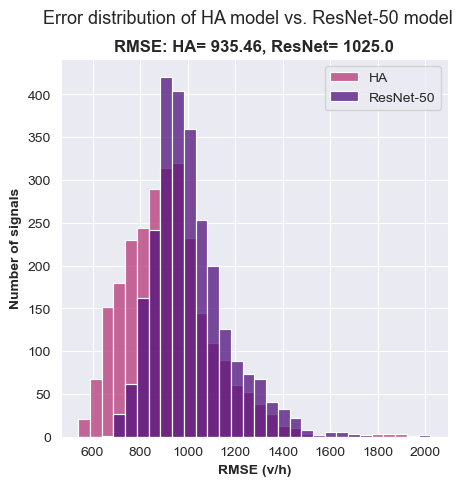

In [24]:
# RMSE dstr of GC-GRNN predictions, RMSE Dstr of ResNet predictions
# RMSE Error distribution shift
#mean_gc = np.mean(RMSE_collect_GC_GRNN)
#mean_rn = np.mean(RMSE_collect_Resnet)

labels =["HA","ResNet-50"]
fig, axes =plt.subplots(figsize=(5,5),dpi=100)
fig.suptitle('Error distribution of HA model vs. ResNet-50 model', fontsize=13)

rmse_plot = sns.histplot(data=[RMSE_collect_Resnet, RMSE_collect_HA], bins=30, kde=False, fill=True)
axes.set_title('RMSE: HA= {}, ResNet= {}'.format(str(round(rmse_ha,2)), str(round(rmse_resnet,2))), fontweight='bold')
axes.legend(labels)
axes.set_xlabel('RMSE (v/h)', fontweight='bold')
axes.set_ylabel('Number of signals', fontweight='bold')

In [25]:
np.argwhere(2.2*RMSE_collect_HA < RMSE_collect_Resnet) #??

array([[ 216],
       [ 504],
       [ 505],
       [ 506],
       [ 577],
       [ 578],
       [ 913],
       [ 914],
       [ 915],
       [ 935],
       [ 936],
       [1249],
       [1250],
       [1251],
       [1727],
       [1728],
       [1729],
       [1754],
       [1922],
       [1943]], dtype=int64)

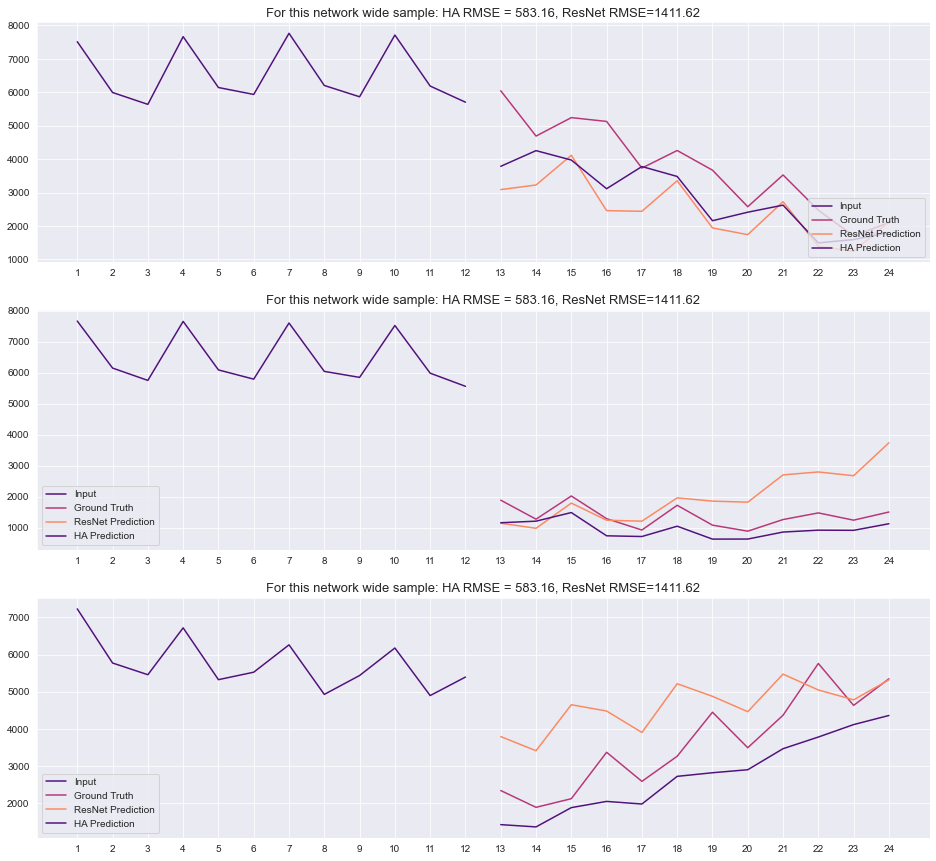

In [26]:
# Do some predictions with the trained model and observe outputs
# Plot corresponding input and corresponding (ResNet Pred, GC-GRNN pred, GT) 
data_select = 915

inpt = inputs[data_select]
gt = gts_test[data_select]
rn_pred = resnet_preds[data_select]
gc_pred = ha_preds[data_select]
er_HA = RMSE_collect_HA[data_select]
er_Resnet = RMSE_collect_Resnet[data_select]

num = 3
inpt = inpt[:,0:num].reshape(num,12)
gt = gt [:,0:num].reshape(num,12)
rn_pred = rn_pred[:,0:num].reshape(num,12)
gc_pred = gc_pred[:,0:num].reshape(num,12)

total_x = np.arange(1,25,1)
x_pred = np.arange(13,25,1)
x_inpt = np.arange(1,13,1)

fig, ax = plt.subplots(num,1,figsize=(16,num*5))

ax[0].plot(x_inpt,inpt[0])
ax[0].plot(x_pred,gt[0])
ax[0].plot(x_pred,rn_pred[0])
ax[0].plot(x_pred,gc_pred[0])
ax[0].set_title(f'For this network wide sample: HA RMSE = {er_HA}, ResNet RMSE={er_Resnet}', fontsize=13);
ax[0].set_xticks(total_x);
ax[0].legend(["Input", "Ground Truth", "ResNet Prediction","HA Prediction" ], loc='lower right')

ax[1].plot(x_inpt,inpt[1])
ax[1].plot(x_pred,gt[1])
ax[1].plot(x_pred,rn_pred[1])
ax[1].plot(x_pred,gc_pred[1])
ax[1].set_title(f'For this network wide sample: HA RMSE = {er_HA}, ResNet RMSE={er_Resnet}', fontsize=13);
ax[1].set_xticks(total_x);
ax[1].legend(["Input", "Ground Truth", "ResNet Prediction","HA Prediction" ], loc='lower left')

ax[2].plot(x_inpt,inpt[2])
ax[2].plot(x_pred,gt[2])
ax[2].plot(x_pred,rn_pred[2])
ax[2].plot(x_pred,gc_pred[2])
ax[2].set_title(f'For this network wide sample: HA RMSE = {er_HA}, ResNet RMSE={er_Resnet}', fontsize=13);
ax[2].set_xticks(total_x);
ax[2].legend(["Input", "Ground Truth", "ResNet Prediction","HA Prediction" ], loc='lower left')